In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools
from customized import preprocess
from customized import metrics
from customized.model import rnns
from customized.model import vae

In [2]:
prod = pd.read_pickle('data/prod.pkl')
txn = pd.read_pickle('data/txn.pkl')
cmt = pd.read_pickle('data/cmt.pkl')
end_date = '2021-11-01'
sub_txn = txn[txn.user_id.isin(['10891','12235','6112','6835','6897','4460','4793'])]
sub_txn.user_id.value_counts()
streamer_static_fname='streamer_static_features_7.csv'

# Customer-streamer

In [3]:
rfm, static_df = preprocess.generate_static_user_context(sub_txn, end_date)
streamer = preprocess.generate_streamer_features(streamer_static_fname, sub_txn, prod, cmt, rfm, end_date) # 製作streamer features
scale_streamer = preprocess.standardize(streamer)     # 標準化

In [9]:
hidden_size = 128
num_layers = 1
num_classes = streamer.shape[0]
input_size = streamer.shape[1]
batch_size = 32
sequence_length = 5
streamer_preds = []
streamer_trues = []
streamer_last_hidden = []
model_path = 'trained_model/customer_streamer/gru_'+str(batch_size)+'_'+str(sequence_length)+'.pth'

# data preprocess
txn_n = preprocess.generate_last_n_txn(sub_txn, sequence_length, end_date)   
cust_id = list(txn_n.groupby(['asid']).last().index)  # keep input's cust_id in order
s_seq = preprocess.generate_streamer_seq(txn_n, scale_streamer, sequence_length)  # input sequences
print(s_seq.shape)
labels_k = dict(zip(streamer.index.to_list(), [i for i in range(streamer.shape[0])])) # user_id as key
s_labels = preprocess.generate_streamer_targets(txn_n, labels_k) # label sequences' targets
dataset = preprocess.StreamerDataset(s_seq, s_labels)
data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        shuffle=False) # 測試集不需要打亂結果也是一樣(因為沒有訓練，是拿已訓練完畢的模型直接產出結果)
# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
streamer_model = rnns.GRU(input_size, hidden_size, num_layers, num_classes)
streamer_model.load_state_dict(torch.load(model_path))
streamer_model.to(device)
streamer_model.eval()

# predict
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for inputs, labels in data_loader:
        inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs, hn = streamer_model(inputs)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        streamer_preds.extend(predicted.detach().cpu().numpy())
        streamer_trues.extend(labels.detach().cpu().numpy())
        streamer_last_hidden.extend(hn[0].cpu().numpy())
    acc = 100.0 * n_correct / n_samples
    print(f'Finall Accuracy: {acc:.4f} %') 

# binds prediction with cust_id
cust_streamer_preds = dict(zip(cust_id, streamer_preds))
print("matching of # of customers incorrects: ",len(list(set(cust_id).difference(set(static_df.asid)))))

付款單號不等於t筆: 0
(37733, 115)
Finall Accuracy: 95.5927 %
matching of # of customers incorrects:  0


In [8]:
np.array(streamer_last_hidden).shape

(37733, 128)

In [46]:
streamer_hn_df = pd.DataFrame(np.array(streamer_last_hidden), index=cust_id, columns=['dim_'+str(i+1) for i in range(np.array(streamer_last_hidden).shape[1])]).reset_index().rename(columns={"index":"asid"})
full_context_hn_user_id = streamer_hn_df.merge(static_df, how='left', on='asid')
full_context_hn = full_context_hn_user_id.set_index('asid')
scale_full_context_hn = preprocess.standardize(full_context_hn.astype(np.float32)).drop(columns='asid').to_numpy()
scale_full_context_hn

array([[ 0.8152154 ,  0.07962336,  1.2016574 , ..., -0.26108813,
        -0.22943813, -0.07427096],
       [ 1.0829996 ,  1.3820958 , -1.2271539 , ..., -0.26108813,
        -0.22943813, -0.07427096],
       [ 1.0515213 ,  1.2436781 , -1.2235461 , ..., -0.26108813,
        -0.22943813, -0.07427096],
       ...,
       [-0.5544598 ,  3.3360562 , -2.0112395 , ..., -0.26108813,
        -0.22943813, -0.07427096],
       [-0.43029225, -0.2693432 ,  0.12696676, ..., -0.26108813,
        -0.22943813, -0.07427096],
       [-0.5544598 ,  3.3360562 , -2.0112395 , ..., -0.26108813,
        -0.22943813, -0.07427096]], dtype=float32)

In [57]:
cust_prod_preds=0
# generate full context (VAE input)
full_context, full_context_wt_user_id = preprocess.generate_full_context(static_df, cust_streamer_preds, cust_prod_preds, streamer, cust_id)
scale_full_context = preprocess.standardize(full_context.astype(np.float32)).drop(columns='asid').to_numpy()
scale_full_context.shape

(37733, 42)

In [61]:
# np.save("data/full_context_wt_user_id.npy", full_context_wt_user_id)
# np.save("data/scale_full_context.npy", scale_full_context)
# np.save("data/full_context_hn_user_id.npy", full_context_hn_user_id)
# np.save("data/scale_full_context_hn.npy", scale_full_context_hn)
# full_context_wt_user_id = np.load('data/full_context_wt_user_id.npy')
# scale_full_context = np.load('data/scale_full_context.npy')
# full_context_hn_user_id = np.load('data/full_context_hn_user_id.npy')
# scale_full_context_hn = np.load('data/scale_full_context_hn.npy')

In [118]:
full_context_wt_user_id

,frequency,recency,T,monetary_value,payment_method_LINE Pay,payment_method_信用卡,payment_method_匯款,payment_method_智慧轉帳,payment_method_自取,payment_method_蝦皮,...,服飾店,精品店,商品與服務,鞋店,居家裝飾,寵物,no_prod,no_orders,no_video,no_engage_cust
asid,,,,,,,,,,,,,,,,,,,,,
1000057940522534,8.0,117.0,129.0,1785.625000,0,0,0,0,0,0,...,0,0,1,0,0,0,80747,810274,275,80980
1000250653732283,41.0,206.0,242.0,565.487805,0,0,0,0,0,0,...,0,0,0,0,0,0,11726,1507619,22,73434
1000394583731592,6.0,153.0,170.0,873.166667,0,0,0,0,0,0,...,0,0,0,0,0,0,11726,1507619,22,73434
1000409986993290,20.0,56.0,56.0,2200.650000,0,1,0,0,0,0,...,1,1,0,0,0,0,8669,813554,14,82814
1000423206992036,186.0,242.0,245.0,1052.887097,0,0,0,0,0,0,...,0,0,0,0,0,0,11726,1507619,22,73434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uf67cf91df3ceb2b644778a5b69e750c7,15.0,61.0,229.0,1537.800000,0,0,0,1,0,0,...,0,0,1,0,0,0,80747,810274,275,80980
Ufb6ae3b97cf51929f0517bfe2484c7fa,19.0,126.0,216.0,1420.789474,0,0,0,0,0,0,...,0,0,1,0,0,0,80747,810274,275,80980
Ufbf7aefd792042c59d84f6fa0e4ad1d7,1.0,0.0,5.0,3500.000000,0,0,0,1,0,0,...,0,0,0,0,0,1,15831,23577,135,3857


In [31]:
cust_id = list(full_context.index)

In [113]:
txn.groupby('場次').商品id.count()

場次
1100921.0                                                 3
2021028.0                                               159
20200418.0                                               38
20200520.0                                                6
20200610.0                                              120
                                                       ... 
6/5                                                      34
https://www.facebook.com/dreamshop168/videos20210928      2
https://www.facebook.com/mgmg1229/videos/60120211108      2
場次：20210716(三郎x深-重播0711公主xC倉晚上B)-俞                        1
荳荳                                                        0
Name: 商品id, Length: 6946, dtype: int64

# VAE for full context

In [115]:
import torch.nn.functional as F
# Hyper-parameters
vae_h_dim = 200
z_dims = [20, 30, 50, 100]
num_epochs = 20
batch_size = 32
learning_rate = 1e-3
weight_eps = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# input_full_context = scale_full_context
input_full_context = scale_full_context_hn
train_data, test_data = train_test_split(input_full_context, test_size=0.33, random_state=2022) # split data
vae_tr_loader = torch.utils.data.DataLoader(dataset=train_data,
                                          batch_size=batch_size, 
                                          shuffle=False)
vae_ts_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size, 
                                          shuffle=False)
input_dim = train_data.shape[1]

for z_dim in z_dims:
    print("z-dim:", z_dim)
    vae_model = vae.VAE(input_dim, vae_h_dim, z_dim, weight_eps).to(device)
    optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)

#     vae_preds = []
#     vae_trues = []
#     blurry_context = []
    for epoch in range(num_epochs):
        for i, x in enumerate(vae_tr_loader):
            x = x.to(device).view(-1, input_dim)
            x_reconst, mu, log_var, z = vae_model(x)
            
            # loss
            loss, reconst_loss, kl_div = vae_model.loss(x_reconst, x, mu, log_var)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 500 == 0:
                print ("Epoch[{}/{}], Step [{}/{}], Total Loss: {:.4f}, Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                       .format(epoch+1, num_epochs, i+1, len(vae_tr_loader), loss.item(), reconst_loss.item(), kl_div.item()))

    torch.save(vae_model.state_dict(), 'trained_model/vae/vae_z-dim_'+str(z_dim)+'.pth')
    with torch.no_grad():
        # 重建
        for i, x in enumerate(vae_ts_loader):
            x = x.to(device).view(-1, input_dim)
            x_reconst, mu, log_var, z = vae_model(x)
            # loss
            loss, reconst_loss, kl_div = vae_model.loss(x_reconst, x, mu, log_var)
            if (i+1) % 500 == 0:
                print ("[Testing] Step [{}/{}], Total Loss: {:.4f}, Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                       .format(i+1, len(vae_tr_loader), loss.item(), reconst_loss.item(), kl_div.item()))

#             vae_preds.extend(x_reconst.detach().cpu().numpy())
#             vae_trues.extend(x.detach().cpu().numpy())
#             blurry_context.extend(z.detach().cpu().numpy())

z-dim: 20
Epoch[1/20], Step [500/791], Total Loss: -90294.6484, Reconst Loss: -91790.4219, KL Div: 1495.7759
Epoch[2/20], Step [500/791], Total Loss: -106668.4688, Reconst Loss: -107762.3125, KL Div: 1093.8438
Epoch[3/20], Step [500/791], Total Loss: -118752.0703, Reconst Loss: -119874.5156, KL Div: 1122.4434
Epoch[4/20], Step [500/791], Total Loss: -126709.9453, Reconst Loss: -127774.5000, KL Div: 1064.5532
Epoch[5/20], Step [500/791], Total Loss: -129461.2969, Reconst Loss: -130402.7812, KL Div: 941.4807
Epoch[6/20], Step [500/791], Total Loss: -128100.9688, Reconst Loss: -128953.4766, KL Div: 852.5084
Epoch[7/20], Step [500/791], Total Loss: -128242.7109, Reconst Loss: -129070.5312, KL Div: 827.8228
Epoch[8/20], Step [500/791], Total Loss: -135511.7969, Reconst Loss: -136326.2812, KL Div: 814.4916
Epoch[9/20], Step [500/791], Total Loss: -138643.9219, Reconst Loss: -139411.5781, KL Div: 767.6599
Epoch[10/20], Step [500/791], Total Loss: -140384.4219, Reconst Loss: -141168.1094, KL D

In [117]:
weight_eps = [2,3,5,10]
z_dim = 50
input_dim = input_full_context.shape[1]
vae_h_dim = 200
num_epochs = 10
batch_size = 32
learning_rate = 1e-3
model_path = 'trained_model/vae/vae_z-dim_50.pth'
data_loader = torch.utils.data.DataLoader(dataset=input_full_context, 
                                        batch_size=batch_size, 
                                        shuffle=False) # 測試集不需要打亂結果也是一樣(因為沒有訓練，是拿已訓練完畢的模型直接產出結果)
# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for w in weight_eps:
    print("weight:", w)
    vae_model = vae.VAE(input_dim, vae_h_dim, z_dim, w).to(device)
    vae_model.load_state_dict(torch.load(model_path))
    vae_model.to(device)
    vae_model.eval()

    # predict
    vae_preds = []
    vae_trues = []
    blurry_context = []

    with torch.no_grad():
        for i, x in enumerate(data_loader):
            x = x.to(device).view(-1, input_dim)
            x_reconst, mu, log_var, z = vae_model(x)
            # loss
            loss, reconst_loss, kl_div = vae_model.loss(x_reconst, x, mu, log_var)
            
            if (i+1) % 500 == 0:
                print ("Step [{}/{}], Total Loss: {:.4f}, Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                       .format(i+1, len(data_loader), loss.item(), reconst_loss.item(), kl_div.item()))

            vae_preds.extend(x_reconst.detach().cpu().numpy())
            vae_trues.extend(x.detach().cpu().numpy())
            blurry_context.extend(z.detach().cpu().numpy())
    print(blurry_context[0])

weight: 2
Step [500/1180], Total Loss: -161749.8750, Reconst Loss: -162495.7188, KL Div: 745.8384
Step [1000/1180], Total Loss: -149256.2031, Reconst Loss: -149935.6094, KL Div: 679.4099
[ 0.8417132  -3.799453   -1.6049535   1.0932035  -0.7541056   0.3509022
 -0.7960842   1.0536981  -0.03656184  0.18001811  0.25767952  0.09889483
 -0.60353327 -1.0305817  -2.0976396   0.12841296 -0.26515085 -2.596345
 -1.5891229   0.2653462  -0.56503946  0.3722338  -3.4485414   4.7058187
  3.1098652   0.02537631 -2.8238845  -1.1707052   1.3890355   1.6328478
 -0.8158206  -0.7704234   0.02153113 -0.17184296 -6.5923495   1.058262
 -1.8393494   0.58471     0.81309265 -1.1356231   1.5405331  -1.2938044
  1.8185774   3.4462264  -0.10437637 -4.242398   -1.3806857   0.41586652
  2.4468238   2.3761303 ]
weight: 3
Step [500/1180], Total Loss: -136998.8594, Reconst Loss: -137744.7031, KL Div: 745.8384
Step [1000/1180], Total Loss: -139690.8438, Reconst Loss: -140370.2500, KL Div: 679.4099
[-1.714263   -3.2309709 

[0.16465136 0.14349218]


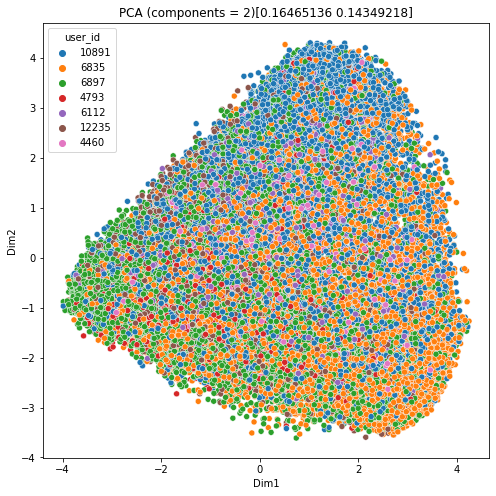

In [103]:
from sklearn.decomposition import PCA

# fit = np.array(blurry_context)
fit = np.array(vae_preds)
pca_model = PCA(n_components=2)
pca_model.fit(fit)
print(pca_model.explained_variance_ratio_)

fit_df = pd.DataFrame(fit, index = cust_id, columns = ['dim_'+str(i+1) for i in range(fit.shape[1])])
pca = pca_model.transform(fit_df)
pca_df = pd.DataFrame(pca, columns=['Dim1','Dim2'])
pca_df_user_id = pd.concat([pca_df, full_context_wt_user_id.reset_index().user_id], axis=1)

fig = plt.figure(figsize=(8,8))
sns.scatterplot(data=pca_df_user_id, x='Dim1', y='Dim2', hue='user_id')
plt.title('PCA (components = 2)'+str(pca_model.explained_variance_ratio_))
plt.savefig(fname='./fig/pca_hn_reconst_user.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

SSE: 38778795784.087395


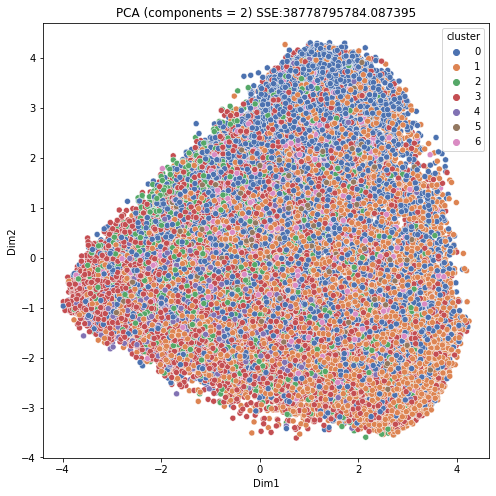

In [104]:
from sklearn.cluster import KMeans

k = 7 # 分幾群
kmeans_model = KMeans(n_clusters=k).fit(full_context)
print("SSE:", kmeans_model.inertia_)
kmeans_cluster = kmeans_model.labels_
pca_df_user_id['cluster'] = pd.Series(list(kmeans_cluster))

fig = plt.figure(figsize=(8,8))
sns.scatterplot(data=pca_df_user_id, x='Dim1', y='Dim2', hue='cluster', palette="deep")
plt.title('PCA (components = 2) SSE:'+str(kmeans_model.inertia_))
plt.savefig(fname='./fig/pca_hn_reconst_cluster.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

In [105]:
from sklearn.manifold import TSNE
import time

s = time.time()
tsne_model = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state = 2022)
tsne = tsne_model.fit_transform(fit)
print('spent: {:.4f} mins'.format((time.time() - s)/60))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 37733 samples in 0.005s...
[t-SNE] Computed neighbors for 37733 samples in 27.475s...
[t-SNE] Computed conditional probabilities for sample 1000 / 37733
[t-SNE] Computed conditional probabilities for sample 2000 / 37733
[t-SNE] Computed conditional probabilities for sample 3000 / 37733
[t-SNE] Computed conditional probabilities for sample 4000 / 37733
[t-SNE] Computed conditional probabilities for sample 5000 / 37733
[t-SNE] Computed conditional probabilities for sample 6000 / 37733
[t-SNE] Computed conditional probabilities for sample 7000 / 37733
[t-SNE] Computed conditional probabilities for sample 8000 / 37733
[t-SNE] Computed conditional probabilities for sample 9000 / 37733
[t-SNE] Computed conditional probabilities for sample 10000 / 37733
[t-SNE] Computed conditional probabilities for sample 11000 / 37733
[t-SNE] Computed conditional probabilities for sample 12000 / 37733
[t-SNE] Computed conditional probabilities for s

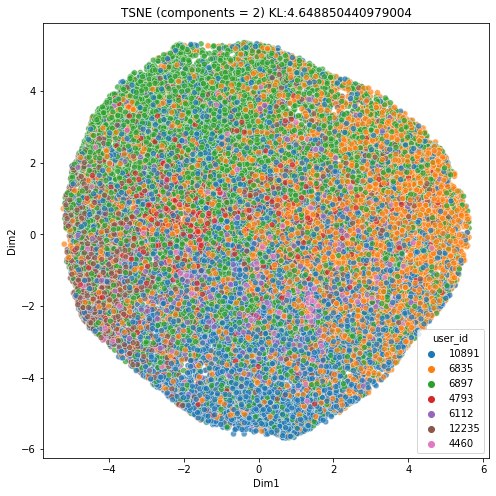

In [108]:
tsne_df = pd.DataFrame(tsne, index = cust_id, columns = ['Dim'+str(i+1) for i in range(tsne.shape[1])])
tsne_df_user_id = pd.concat([tsne_df.reset_index(), full_context_wt_user_id.reset_index().user_id], axis=1).rename(columns={'index':'asid'})
tsne_df_user_id['cluster'] = pd.Series(list(kmeans_cluster))

plt.figure(figsize=(8,8))
sns.scatterplot(
    data=tsne_df_user_id,
    x="Dim1", y="Dim2",
    hue="user_id",
    legend="full",
    alpha=0.7
)
plt.title('TSNE (components = 2) KL:'+str(tsne_model.kl_divergence_))
plt.savefig(fname='./fig/tsne_hn_reconst_user.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

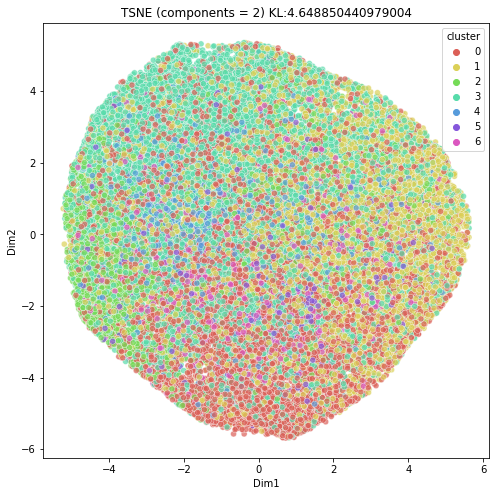

In [109]:
plt.figure(figsize=(8,8))
sns.scatterplot(
    data=tsne_df_user_id,
    x="Dim1", y="Dim2",
    hue="cluster",
    palette=sns.color_palette("hls", k),
    legend="full",
    alpha=0.7
)
plt.title('TSNE (components = 2) KL:'+str(tsne_model.kl_divergence_))
plt.savefig(fname='./fig/tsne_hn_reconst_cluster.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

In [22]:
prod_n = pd.read_pickle('data/prod_n.pkl')
prod_n

,asid,付款單號,商品id,cnt,seq
0,1000057940522534,PA210625-08456886,3740398,1,1
1,1000057940522534,PA210625-08456886,3740432,1,1
2,1000057940522534,PA210625-08456886,3742657,1,1
3,1000057940522534,PA210625-08456886,3742823,1,1
4,1000057940522534,PA210625-08456886,3743199,1,1
...,...,...,...,...,...
3243221,Ufd9f8919382ca4899c4090af496b7d8f,PA211017-11612594,4978789,1,2
3243222,Ufd9f8919382ca4899c4090af496b7d8f,PA211017-11612642,4978802,1,3
3243223,Ufd9f8919382ca4899c4090af496b7d8f,PA211017-11612676,4978805,1,4
3243224,Ufd9f8919382ca4899c4090af496b7d8f,PA211017-11612691,4978807,1,5


In [34]:
len(set(prod.id))

280151

In [36]:
len(set(prod_n.商品id))

103032

In [35]:
# product = preprocess.generate_prodcut_features(prod)
# pd.to_pickle(product,'data/prod_features.pkl')
id_list = list(set(prod_n.商品id))
path = 'id_list_VAE.txt'
f = open(path, 'w')
for items in id_list:
    f.writelines(items+',\n')
f.close()

In [ ]:
b_seq_df = prod_n[(prod_n.seq <= t)].merge(scale_product_feature, how='left', left_on='商品id', right_on='id').fillna(0).groupby(['asid','seq']).mean().reset_index()

In [6]:
product = preprocess.generate_prodcut_features(prod)
scale_prod = preprocess.standardize(product)
prod_n = pd.read_pickle('data/prod_n.pkl')
sequence_length = 5
b_seq = preprocess.generate_basket_seq(prod_n, scale_prod, sequence_length)
b_seq.shape

不在商品主檔的商品共有: 0個


(44028, 2350)

In [9]:
# b_seq = np.load('data/b_seq.npy')
b_seq

array([[-0.04622747, -0.3227686 ,  0.3196153 , ..., -0.26120243,
        -0.30875266, -0.24138723],
       [-0.05877909,  3.04895271,  0.3196153 , ..., -0.26120243,
         3.23883847, -0.24138723],
       [-0.059012  ,  2.37460845,  0.3196153 , ..., -0.26120243,
         3.23883847, -0.24138723],
       ...,
       [-0.03810128, -0.3227686 , -3.12876131, ..., -0.26120243,
        -0.30875266, -0.24138723],
       [ 0.01365795, -0.3227686 ,  0.3196153 , ..., -0.26120243,
        -0.30875266,  4.14272125],
       [-0.03810128, -0.3227686 , -3.12876131, ..., -0.26120243,
        -0.30875266, -0.24138723]])

In [18]:
prod_n[prod_n.seq == sequence_length+1]

,asid,付款單號,商品id,cnt,seq
18,1000057940522534,PA210902-10386443,4482154,1,6
19,1000057940522534,PA210902-10386443,4482404,1,6
20,1000057940522534,PA210902-10386443,4482535,1,6
21,1000057940522534,PA210902-10386443,4482661,1,6
48,1000250653732283,PA210426-07057088,3137434,1,6
...,...,...,...,...,...
3243180,Ufbf7aefd792042c59d84f6fa0e4ad1d7,PA211027-11908194,5082308,1,6
3243217,Ufce24295f514cbf0a16f4634d0ba5155,PA210614-08169948,3613300,1,6
3243218,Ufce24295f514cbf0a16f4634d0ba5155,PA210614-08169948,3613481,1,6
3243219,Ufce24295f514cbf0a16f4634d0ba5155,PA210614-08169948,3613857,1,6


In [15]:
len(set(prod_n[prod_n.seq == sequence_length+1].商品id))

48571

In [71]:
import torchbnn as bnn
blurry_context = np.reshape(blurry_context, (len(blurry_context), z_dim))
h1_dim = 400
h2_dim = 200
num_prod_t1 = len(set(prod_n[prod_n.seq == sequence_length+1].商品id))

bnn_model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=z_dim, out_features=h1_dim),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=h1_dim, out_features=h2_dim),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=h2_dim, out_features=num_prod_t1),
)
ce_loss = nn.CrossEntropyLoss() # softmax
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(bnn_model.parameters(), lr=0.01)

for step in range(3000):
    pre = model(x)
    ce = ce_loss(pre, y)
    kl = kl_loss(model)
    cost = ce + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
_, predicted = torch.max(pre.data, 1)
total = y.size(0)
correct = (predicted == y).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))


# 1. load training data
train_ldr = torch.utils.data.DataLoader(train_ds,

# 2. create network
bnn_model = bnn_model().to(device)

# 3. train model (could put this into a train() function)
num_epochs = 10
ep_log_interval = 10

ce_loss = T.nn.CrossEntropyLoss()   # applies softmax()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
optimizer = T.optim.Adam(net.parameters(), lr=0.01)

print("\nbat_size = %3d " % bat_size)
print("loss = highly customized ")
print("optimizer = Adam 0.01")
print("max_epochs = %3d " % max_epochs)

print("\nStarting training")
net.train()
for epoch in range(0, num_epochs):
epoch_loss = 0  # for one full epoch
num_lines_read = 0

for (batch_idx, batch) in enumerate(train_ldr):
  X = batch['predictors']  # [10,4]
  Y = batch['species']  # alreay flattened
  optimizer.zero_grad()
  oupt = net(X)

  cel = ce_loss(oupt, Y)
  kll = kl_loss(net)
  tot_loss = cel + (0.10 * kll)

  epoch_loss += tot_loss.item()  # accumulate
  tot_loss.backward()  # update wt distribs
  optimizer.step()

if epoch % ep_log_interval == 0:
  print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss))
print("Training done ")

# 4. evaluate model accuracy
print("\nComputing Bayesian network model accuracy")
net.eval()
acc = accuracy_quick(net, train_ds)  # item-by-item
print("Accuracy on train data = %0.4f" % acc)

# 5. make a prediction
print("\nPredicting species for [5.0, 2.0, 3.0, 2.0]: ")
x = np.array([[5.0, 2.0, 3.0, 2.0]], dtype=np.float32)
x = T.tensor(x, dtype=T.float32).to(device) 

for i in range(3):
with T.no_grad():
  logits = net(x).to(device)  # values do not sum to 1.0
probs = T.softmax(logits, dim=1).to(device)
print(probs.numpy())

print("\nEnd Bayesian network demo ")


[array([-0.2371279 , -0.9050108 , -1.9776264 , -0.388443  , -1.6513762 ,
         1.686593  , -0.78375816, -0.22143596,  0.6529555 ,  2.0109634 ,
        -0.40994248, -2.316667  , -1.8950253 , -0.22153015,  0.34470797,
        -0.47616577, -0.38084087,  0.1339893 ,  0.9475062 , -1.583943  ],
       dtype=float32),
 array([ 8.8730633e-02,  1.1896488e-01,  2.7285907e+00, -2.6688725e-01,
         2.4044514e-03, -5.7385027e-01,  2.1996093e-01, -1.9667697e+00,
         6.2722182e-01, -5.6988341e-01,  1.0435712e+00,  3.6295703e-01,
         8.2786560e-02,  7.4808472e-01, -3.2820973e-01, -1.1955541e+00,
        -9.2273414e-01,  2.4599043e-01, -9.2441916e-02, -7.2237718e-01],
       dtype=float32),
 array([-1.25704   , -1.1957953 ,  2.0764413 , -1.7920663 ,  1.1355671 ,
        -0.93935144, -0.08519977, -0.7235825 , -0.6504587 , -1.4159663 ,
         0.36466685,  0.59110194,  0.27460492, -0.18474217,  1.5496415 ,
        -0.93290555, -1.8025317 ,  0.20802432,  1.6218884 , -0.49849206],
       